## Aetherios Flight Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rocketpy
import csv
import CoolProp.CoolProp as CP

# this provides access to many physical constants
from scipy import constants

# Module used to parse and work with units
from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity

### Stability Calculations (from openrocket outputs)

TODO:

Essentially everything

In [2]:
# Load Data from OpenRocket simulation CSV (sim_master_data.csv)
Data_Folder = f"../openrocket_sims/Aetherios_sim_master/sim_master_data.csv"
sim_data = pd.read_csv(Data_Folder)
print(sim_data)

      # Time (s)  Altitude (m)  Vertical velocity (m/s)  \
0          0.010     -0.000467                   -0.093   
1          0.020     -0.000421                   -0.084   
2          0.030     -0.000375                   -0.075   
3          0.040     -0.000329                   -0.066   
4          0.050     -0.000284                   -0.057   
...          ...           ...                      ...   
3032     734.406      5.796000                   -5.058   
3033     734.664      4.498000                   -5.034   
3034     735.164      1.976000                   -5.054   
3035     735.522      0.167000                   -5.048   
3036     735.555      0.000000                   -5.044   

      Vertical acceleration (m/s²)  Total velocity (m/s)  \
0                           -9.334                 0.093   
1                           -8.418                 0.084   
2                           -7.502                 0.075   
3                           -6.585                 

In [3]:
# find dynamic pressure curve through flight 
# dynamic pressure = 0.5 * rho * v^2
# rho = density of air = P / (R * T)
# P = pressure, R = specific gas constant, T = temperature
# v = velocity

P = Q_(sim_data['Air pressure (mbar)'].values/1000, 'bar').to('Pa').magnitude
T = Q_(sim_data['Air temperature (°C)'].values, 'degC').to('K').magnitude
V = Q_(sim_data['Total velocity (m/s)'].values, 'm/s').magnitude

air_density = P / (287.05 * T)

# Calculate dynamic pressure
dynamic_pressure_psi = 0.5 * air_density * V**2

# Find max dynamic pressure and its corresponding time
max_dynamic_pressure = np.max(dynamic_pressure_psi)
max_dynamic_pressure_index = np.argmax(dynamic_pressure_psi)
max_dynamic_pressure_time = sim_data['# Time (s)'].iloc[max_dynamic_pressure_index]

# Convert max dynamic pressure to psi
max_dynamic_pressure_psi = Q_(max_dynamic_pressure, 'Pa').to('psi').magnitude

# Convert vertical velocity to ft/s
vertical_velocity_filtered = sim_data['Vertical velocity (m/s)'][:len(time_filtered)] * 3.28084

# Find max vertical velocity
max_vertical_velocity = np.max(vertical_velocity_filtered)

# Filter data to only plot up to 100 seconds
time_filtered = sim_data['# Time (s)'][sim_data['# Time (s)'] <= 100]
dynamic_pressure_filtered = Q_(dynamic_pressure_psi[:len(time_filtered)], 'Pa').to('psi').magnitude

# Print the max dynamic pressure in Pa and psi
print(f"Max dynamic pressure: {max_dynamic_pressure:.2f} Pa ({max_dynamic_pressure_psi:.2f} psi)")

# Plot dynamic pressure vs time
fig, ax1 = plt.subplots()

# Primary axis: Dynamic pressure
ax1.plot(time_filtered, dynamic_pressure_filtered, label='Dynamic Pressure', color='b')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Dynamic Pressure (psi)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Add a horizontal line for max dynamic pressure
ax1.axhline(y=max_dynamic_pressure_psi, color='r', linestyle='--', label='Max Dynamic Pressure')

# Add a vertical line at the time of max dynamic pressure
ax1.axvline(x=max_dynamic_pressure_time, color='g', linestyle='--', label=f'Time at Max Q: {max_dynamic_pressure_time:.2f}s')

# Secondary axis: Vertical velocity
ax2 = ax1.twinx()
ax2.plot(time_filtered, vertical_velocity_filtered, label='Vertical Velocity', color='orange')
ax2.set_ylabel('Vertical Velocity (ft/s)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and legend
plt.title(f'Dynamic Pressure and Vertical Velocity vs Time\nMax Q: {max_dynamic_pressure_psi:.2f} psi, Max Velocity: {max_vertical_velocity:.2f} ft/s')
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.show()


NameError: name 'time_filtered' is not defined

In [4]:
def find_fin_force (fin_area, dynamic_pressure_psi, fin_angle):
    
    # Calculate fin force
    pressure_axial = dynamic_pressure_psi * np.sin(np.deg2rad(fin_angle))
    
    fin_force = fin_area * pressure_axial
    
    return fin_force, pressure_axial

f_force, pressure_fin = find_fin_force(fin_area=160, dynamic_pressure_psi=max_dynamic_pressure_psi, fin_angle=5)
f_force = Q_(f_force, 'lbf')
pressure_fin = Q_(pressure_fin, 'psi')

print(f'Fin force: {f_force}')
print(f'Pressure on fin: {pressure_fin}')

Fin force: 219.6816961493499 force_pound
Pressure on fin: 1.3730106009334369 pound_force_per_square_inch


### RocketPy Flight Simulation (flight dispersions) 

In [5]:
# general imports 
from rocketpy import (
    Function,
    LiquidMotor,
    UllageBasedTank,
    MassBasedTank,
    Fluid,
    Rocket,
    Flight,
    Environment,
    CylindricalTank,
    MonteCarlo, 
)

# imports for stochastic analysis
from rocketpy.stochastic import (
    StochasticEnvironment,
    StochasticSolidMotor,
    StochasticRocket,
    StochasticFlight,
    StochasticNoseCone,
    StochasticTail,
    StochasticTrapezoidalFins,
    StochasticParachute,
    StochasticRailButtons,  
    StochasticGenericMotor, 
)

/opt/anaconda3/envs/aetherios_vehicle_analysis-env/lib/python3.11/site-packages/rocketpy/environment/tools.py:309: UserWarning: Exact chosen launch time is not available in the provided file, using 2025-02-06 21:00:00 UTC instead.
  warnings.warn(



Gravity Details

Acceleration of gravity at surface level:    9.7948 m/s²
Acceleration of gravity at  79.623 km (ASL): 9.5565 m/s²


Launch Site Details

Launch Date: 2025-02-06 20:00:00 UTC | 2025-02-06 12:00:00 America/Los_Angeles
Launch Site Latitude: 35.34722°
Launch Site Longitude: -117.80806°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 426575.58 W    3911849.32 N
Launch Site UTM zone: 11S
Launch Site Surface Elevation: 905.9 m


Atmospheric Model Details

Atmospheric Model Type: forecast
forecast Maximum Height: 79.623 km

Surface Atmospheric Conditions

Surface Wind Speed: 2.25 m/s
Surface Wind Direction: 242.73°
Surface Wind Heading: 62.73°
Surface Pressure: 908.62 hPa
Surface Temperature: 276.90 K
Surface Air Density: 1.143 kg/m³
Surface Speed of Sound: 333.58 m/s


Earth Model Details

Earth Radius at Launch site: 6371.02 km
Semi-major Axis: 6378.14 km
Semi-minor Axis: 6356.75 km
Flattening: 0.0034


Atmospheric Model Plots



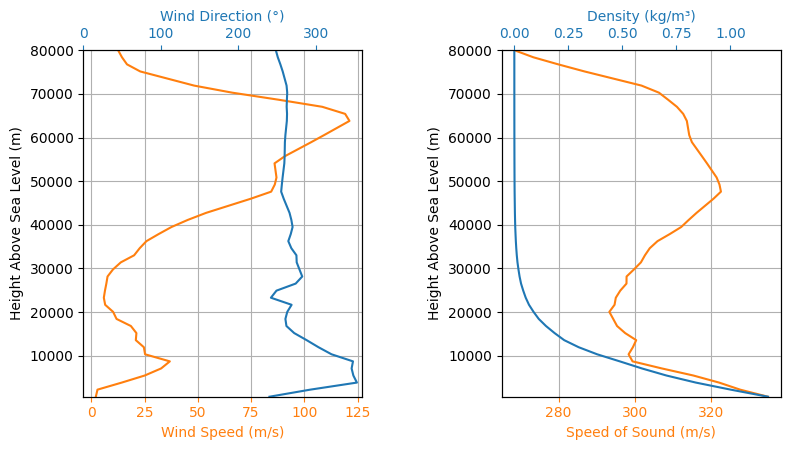

[  2.16222281   2.15955405   2.16093718   2.16453741   2.30121126
   2.40456834   2.63928295   3.09580196   5.72486031  12.96613858
  15.42804342  17.62820983  25.07926937  30.78930774  32.79561325
  32.72994261  38.2821266   25.22234798  25.55409581  20.90383014
  21.36524375  11.88506872   9.77506285   5.70043646   5.99265438
   7.05466607   7.69729468  12.21842102  21.46501581  23.73160645
  36.37839252  50.22537616  84.2367275   87.09505017  85.889611
 105.59774803 124.24366537 107.10130288  53.6528049   18.27145433
  12.6141538 ]
[240.44377047 240.45075301 240.37827198 240.36242773 243.97290524
 259.13302465 281.43770711 299.35743805 332.25011722 351.39649985
 354.71602413 351.26110997 348.65700546 346.16590532 346.51339982
 344.14165073 349.53073726 322.46505536 306.98571821 289.0389249
 262.84545118 260.95380644 264.11685828 270.25331745 231.5646028
 273.63823513 283.40625267 275.6344228  275.10383466 263.51360709
 270.50729953 267.60819803 255.40638704 256.89554444 259.81515798

TypeError: 'int' object is not iterable

In [7]:
# define enviroment 
env = Environment(
    latitude=35.347222, 
    longitude=-117.808056, 
    elevation=627   # the launch site elevation in meters
    ) 

# set the launch date/time
env.set_date(
    date=[2025, 2, 6, 12], # (year, month, day, hour)
    timezone="America/Los_Angeles"
    )

# Set the atmospheric model using a NOAA forecast
env.set_atmospheric_model(
    type="forecast",
    file="GFS",          # or "RAP" or "GFS"
    dictionary="NOAA"    # NOAA variable naming convention
)

env.info()
wind_alt = env.height
wind_speed = env.wind_speed(wind_alt)
print(wind_speed)
wind_direction = env.wind_direction(wind_alt)
wind_std = [5]*len(wind_alt)
print(wind_direction)
with open("wind_GFS.txt", 'w', newline='') as csvfile:
    resultwriter = csv.writer(csvfile, delimiter=' ')
    resultwriter.writerow(["# altitude (m)",
                        "wind direction (°)",
                        "wind speed (m/s)",
                        "direction std deviation (°)"])

    for alt, direction, speed, std in zip(
            wind_alt, wind_direction, wind_speed, wind_std):

        resultwriter.writerow([
            "%.2f" % alt,
            "%.2f" % direction,
            "%.2f" % speed,
            "%.2f" % std,])

### Tank and Rocket Definition

In [6]:
# Misc Functions

def generate_tank_volume_csv(
        filename: str, 
        volumetric_flow_rate: float,
        time, 

):
    """
    Generate a CSV of tank volume over time for a given volumetric flow rate

    :param filename: str: name of the file to save the data to
    :param volumetric_flow_rate: float: volumetric flow rate of the tank
    :param time: float: time in seconds to run the simulation
    """

    # find the volume of the tank
    tank_volume = volumetric_flow_rate * time

    # generate time array
    times = np.linspace(0, time, 1000)
    print(np.max(times))

    # generate volume array
    volumes = np.linspace(tank_volume, 0, 1000)

    # write to CSV
    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Time (s)", "Volume (m³)"])
        for t, v in zip(times, volumes):
            writer.writerow([t, v])  

In [7]:
# Constants
burn_time = 20
Fuel_Vdot = 0.0011 # m^3/s ETH Volumetric Flow Rate 
Ox_Vdot = 0.0009071486760215769 # m^3/s LOX Volumetric Flow Rate 

#### Ethanol Tank

20.0


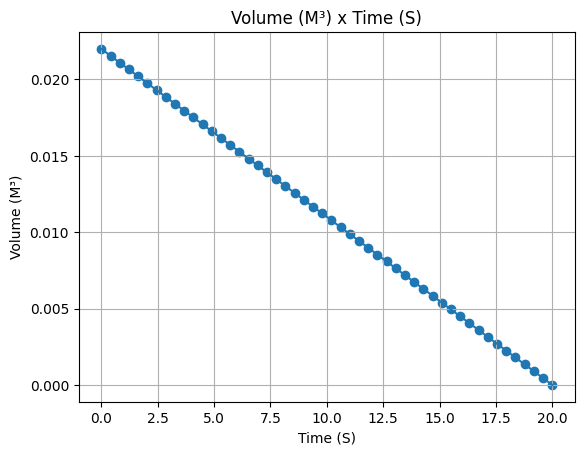

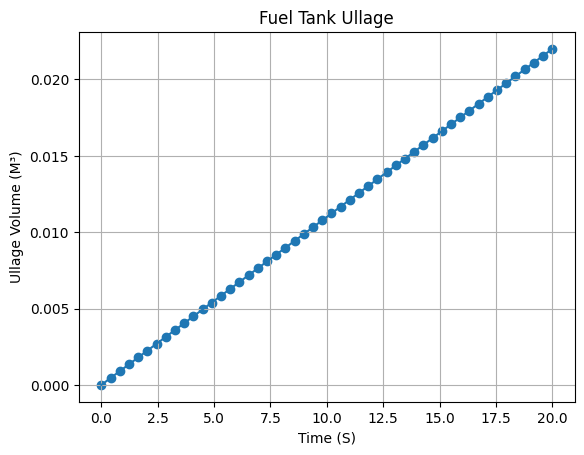

In [8]:
generate_tank_volume_csv("Fuel_Volumes.csv", Fuel_Vdot, burn_time)
 
#  Define and set up Fuel volume
fuel_volume = Function(
    "Fuel_Volumes.csv",
    inputs="Time (s)",
    outputs="Volume (m³)",
)

fuel_volume.set_discrete(0, burn_time, 50, interpolation="linear")
fuel_volume.set_outputs("Volume (m³)")

# Plot Fuel volume
fuel_volume.plot(force_data=True)

# Define and set up Fuel tank ullage
fuel_tank_ullage = Fuel_Vdot*burn_time - fuel_volume
fuel_tank_ullage.set_title("Fuel Tank Ullage")
fuel_tank_ullage.set_outputs("Ullage volume (m³)")

# Plot Fuel tank ullage
fuel_tank_ullage.plot(force_data=True)

#### Liquid Oxygen Tank

20.0


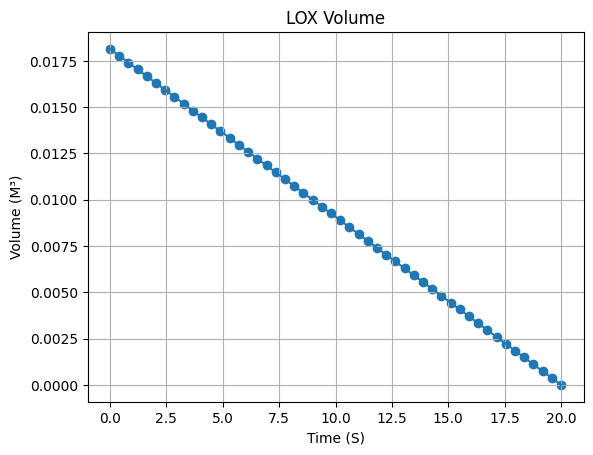

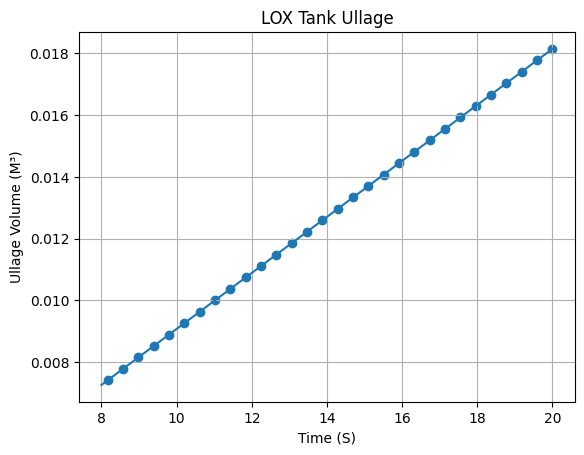

In [9]:
generate_tank_volume_csv("Ox_Volumes.csv", Ox_Vdot, burn_time)

# Define and set up LOX volume
lox_volume = Function(
    "Ox_Volumes.csv",
    extrapolation="zero",
    inputs="Time (s)",
    outputs="Volume (m³)",
)
lox_volume.set_discrete(0, burn_time, 50, interpolation="linear")
lox_volume.set_outputs("Volume (m³)")
lox_volume.set_title("LOX Volume")

# Plot LOX volume
lox_volume.plot(force_data=True)

# Define and set up LOX tank ullage
lox_tank_ullage = Ox_Vdot*burn_time - lox_volume
lox_tank_ullage.set_title("LOX Tank Ullage")
lox_tank_ullage.set_outputs("Ullage volume (m³)")

# Plot LOX tank ullage
lox_tank_ullage.plot(8, 20, force_data=True)

In [10]:
# Define fluids 
P = Q_(500, "psi")
P_COPV = Q_(4500, "psi")
T = Q_(70, "degF")

# Fuel 
fuel_rho = CP.PropsSI('D', 'P', P.to("Pa").magnitude, 'T', T.to('K').magnitude, 'Ethanol') 
fuel_rho = Q_(fuel_rho, "kg/m^3")
print(f"Fuel Density: {fuel_rho}")

# Ox
ox_rho = 948.19
ox_rho = Q_(ox_rho, "kg/m^3")
print(f"Ox Density: {ox_rho}")

# Pressurant 
Rho_postreg = CP.PropsSI('D', 'P', P.to("Pa").magnitude, 'T', T.to('K').magnitude, 'Helium')
Rho_prereg = CP.PropsSI('D', 'P', P_COPV.to("Pa").magnitude, 'T', T.to('K').magnitude, 'Helium')

lox = Fluid(name="LOX", density=ox_rho.to("kg/m^3").magnitude)
fuel = Fluid(name="Ethanol", density=fuel_rho.to("kg/m^3").magnitude)

# Define pressurizing gases with their respective pressures
lox_tank_pressurizing_gas = Fluid(name="Helium", density=Rho_postreg)  # 500 PSI
fuel_tank_pressurizing_gas = Fluid(name="Helium", density=Rho_postreg)  # 500 PSI
pressurizing_gas = Fluid(name="Helium", density=Rho_prereg)  # 4500 PSI

Fuel Density: 791.4048980144883 kilogram / meter ** 3
Ox Density: 948.19 kilogram / meter ** 3


### Tank Definition

Lox tank

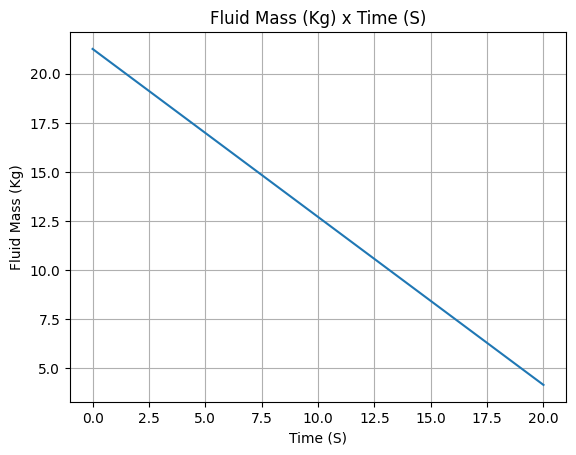

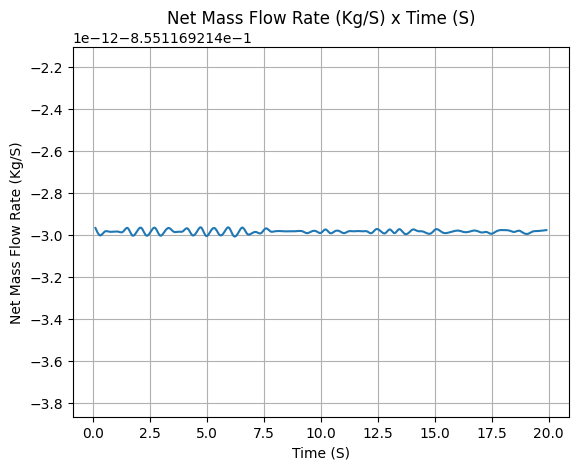

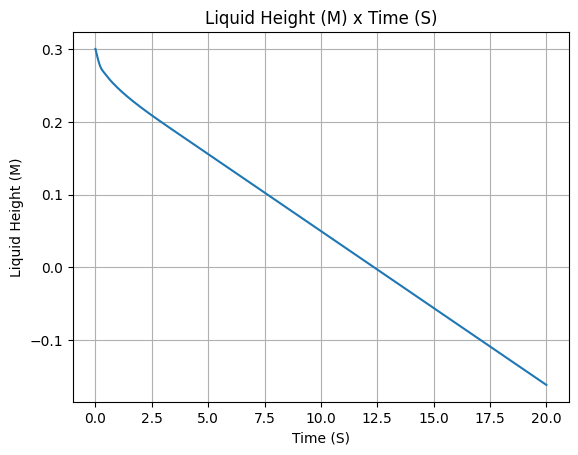

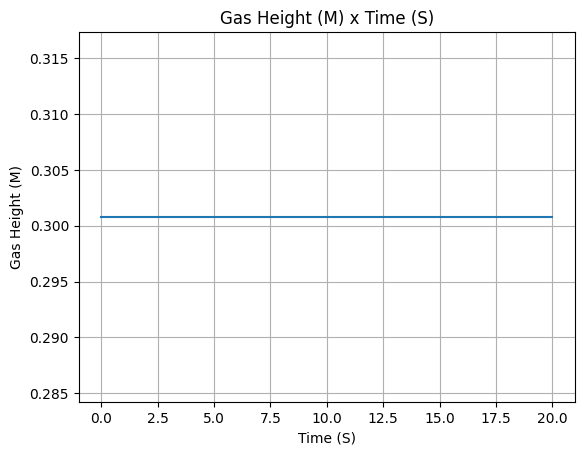

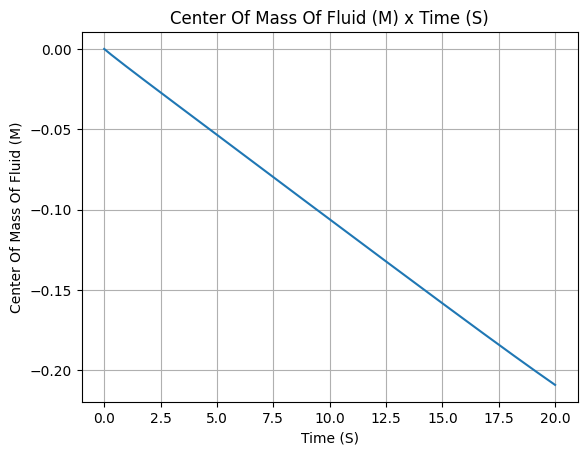

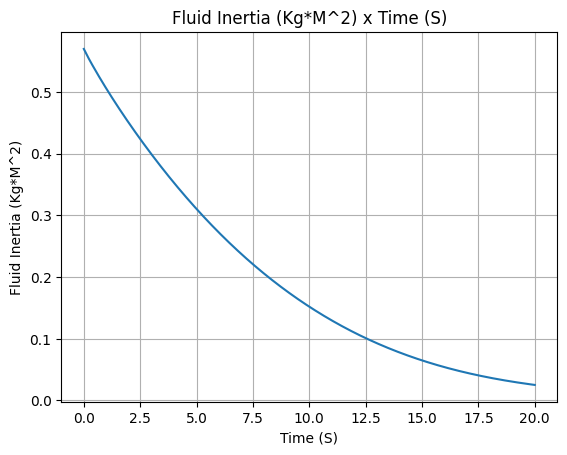

In [11]:
lox_tank_height = Q_(23.684, "in")
lox_tank_radius = Q_(9.192/2, "in")

lox_tank_geometry = CylindricalTank(
    radius=lox_tank_radius.to("m").magnitude, 
    height=lox_tank_height.to("m").magnitude, 
    spherical_caps=True
    )

lox_tank = UllageBasedTank(
    name="LOX Tank",
    flux_time=(0, 20),
    geometry=lox_tank_geometry,
    gas=lox_tank_pressurizing_gas,
    liquid=lox,
    ullage=lox_tank_ullage,
)

# Results 
lox_tank.fluid_mass()
lox_tank.net_mass_flow_rate()
lox_tank.liquid_height()
lox_tank.gas_height()
lox_tank.center_of_mass()
lox_tank.inertia()

Fuel Tank

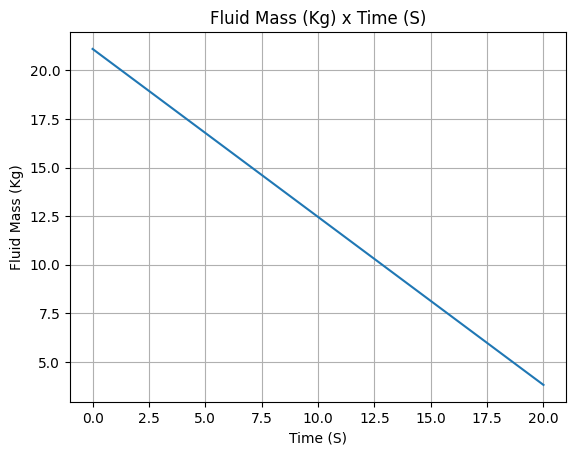

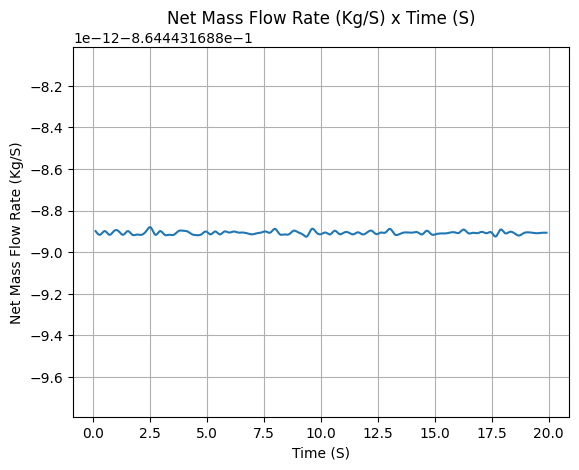

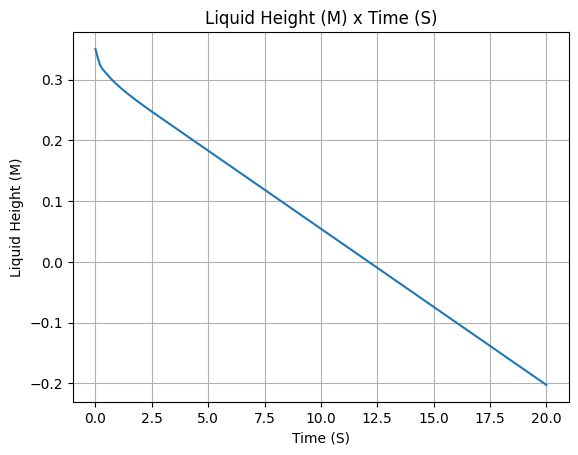

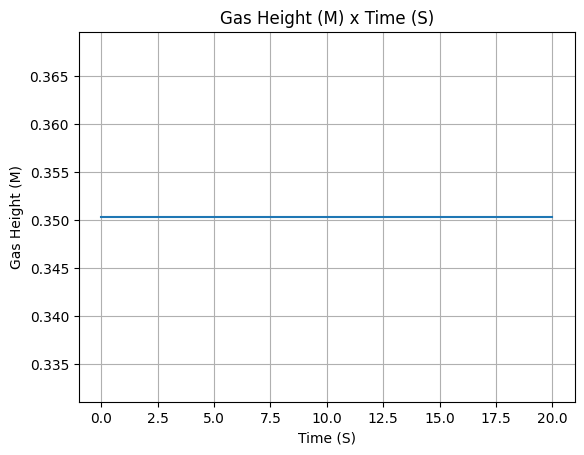

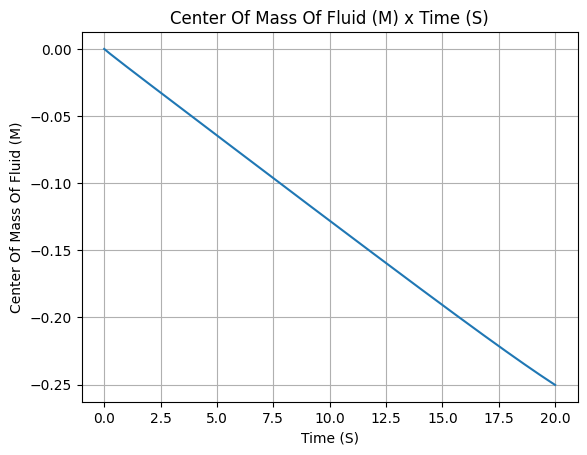

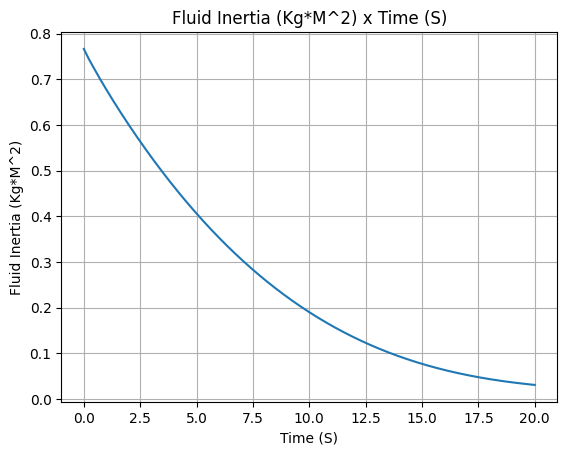

In [12]:
fuel_tank_height = Q_(27.586, "in")
fuel_tank_radius = Q_(9.192/2, "in")

fuel_tank_geometry = CylindricalTank(
    radius=fuel_tank_radius.to("m").magnitude, 
    height=fuel_tank_height.to("m").magnitude, 
    spherical_caps=True
    )

fuel_tank = UllageBasedTank(
    name="Fuel Tank",
    flux_time=(0, 20),
    geometry=fuel_tank_geometry,
    gas= fuel_tank_pressurizing_gas,
    liquid=fuel,
    ullage=fuel_tank_ullage,
)

# Results
fuel_tank.fluid_mass()
fuel_tank.net_mass_flow_rate()
fuel_tank.liquid_height()
fuel_tank.gas_height()
fuel_tank.center_of_mass()
fuel_tank.inertia()


Pressurant Tank

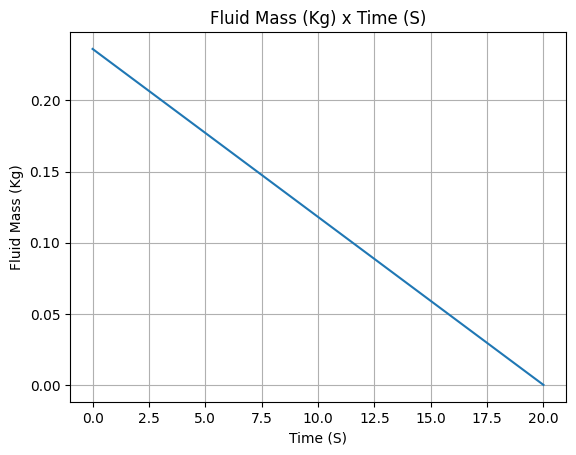

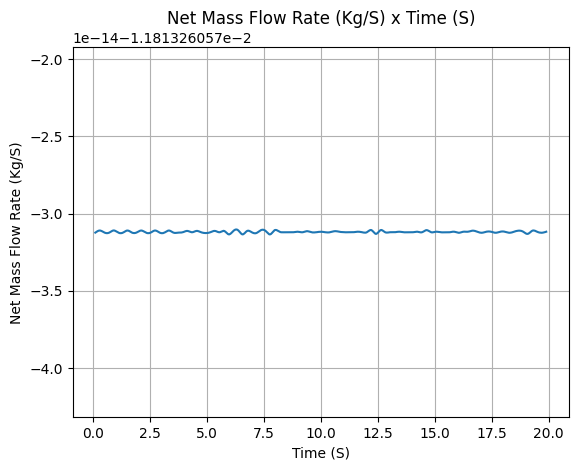

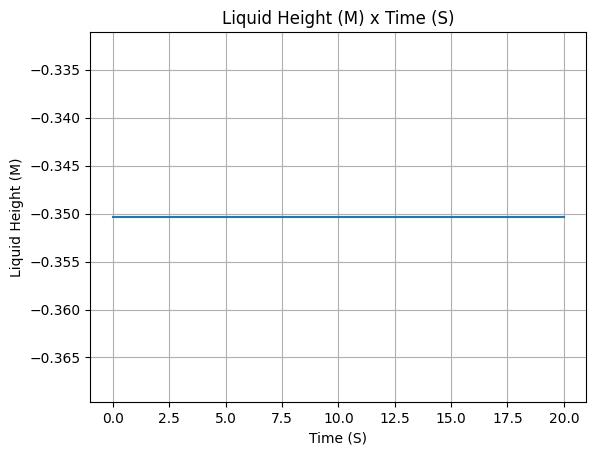

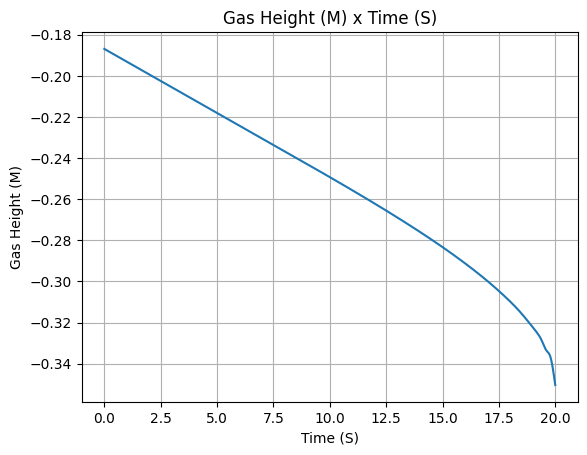

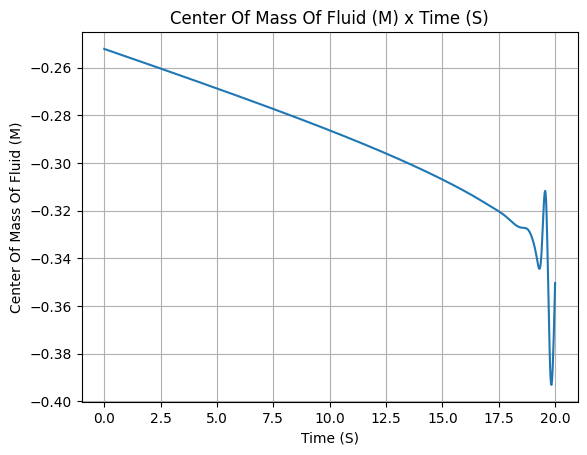

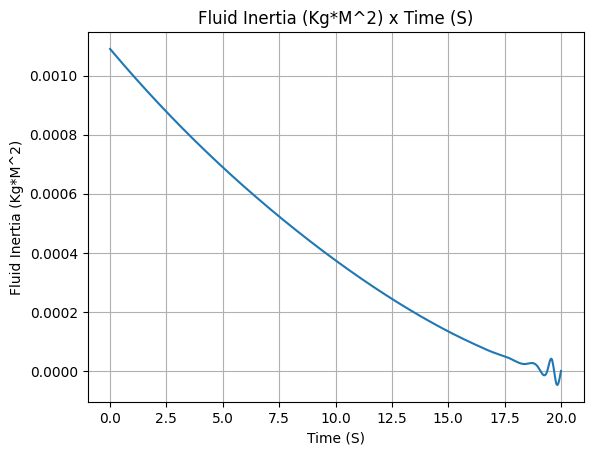

In [14]:
pressurant_tank_height = Q_(20.3, "in")
pressurant_tank_radius = Q_(6.26/2, "in")

pressure_tank_geometry = CylindricalTank(
    radius=fuel_tank_radius.to("m").magnitude, 
    height=fuel_tank_height.to("m").magnitude, 
    spherical_caps=True
    )
 
M_He0 = 0.23626521133062392   # [kg] total initial helium mass
m_dot = 0.011813260566531196  # [kg/s] constant outflow mass rate
t_end = 20   # [s] duration of outflow

def helium_mass(t):
    """
    Returns the helium mass in kg at time t (in seconds).
    """
    if t < 0:
        # Before time 0, mass is just initial mass
        return M_He0
    
    if 0 <= t < t_end:
        # Linearly decreasing from M_He0 to M_He0 - m_dot * t_end
        return M_He0 - m_dot * t
    
    # After t_end, no more flow or mass goes to zero if exhausted
    final_mass = M_He0 - m_dot * t_end
    return max(final_mass, 0)

pressure_tank = MassBasedTank(
    name="Pressure Tank",
    geometry=pressure_tank_geometry,
    liquid_mass=0,
    flux_time=(0, 20),
    gas_mass=helium_mass,
    gas=pressurizing_gas,
    liquid=pressurizing_gas,
)

pressure_tank.fluid_mass()
pressure_tank.net_mass_flow_rate()
pressure_tank.liquid_height()
pressure_tank.gas_height()
pressure_tank.center_of_mass()
pressure_tank.inertia()

Create Liquid Motor

In [ ]:
liquid_motor = LiquidMotor(
    thrust_source="../../data/rockets/berkeley/test124_Thrust_Curve.csv",
    center_of_dry_mass_position=0,
    dry_inertia=(0, 0, 0),
    dry_mass=0,
    burn_time=(0, 20),
    nozzle_radius=0.069 / 2,
    nozzle_position=-1.364,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)

liquid_motor.add_tank(propane_tank, position=-0.6446)
liquid_motor.add_tank(lox_tank, position=1.1144)
liquid_motor.add_tank(pressure_tank, position=2.4975)